# <font color = 'green'>Purpose of this Notebook:</font>
### <font color = 'blue'>To model the GCSEs data from []() and determine the best one</font>

## Index

  <a href='#notebook_setup'>Notebook Set up</a><br />
1)  <a href='#x_y'>Set up X & y</a><br />
2)  <a href='#ols'>Models 1-3) (Regularised) Ordinary Least Squares (OLS) regression</a><br />
4)  <a href='#dt'>Decision Tree</a><br />
5)  <a href='#ensemble'>Models 5-7) Ensemble Methods (all with Decision Tree)</a><br />
&emsp;&emsp;&emsp;5)  <a href='#bagging'>Bagging</a><br />
&emsp;&emsp;&emsp;6)  <a href='#rf'>Random Forest</a><br />
&emsp;&emsp;&emsp;7)  <a href='#ada'>AdaBoost</a><br />
6)  <a href='#pca'>Model 8) Principal Component Analysis (PCA)</a><br />
7)  <a href='#8'>Results Summary</a><br />

<a id='notebook_setup'></a>

# <font color='blue'>Notebook Set up (import modules and data)</font>

In [1]:
# import the libraries and modules that will be needed

import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error

# for reading and later saving csvs
from pandas import read_csv
import csv

# Decision Tree graphics
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

# for saving model outputs
import pickle

# for graphs
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/Users/jacktyler-whittle/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
# import base data

df = read_csv('data_files/england_ks4final17_18.csv')
df_model = pd.read_csv('data_files/final_full_feat_gcse_2018.csv')

/Users/jacktyler-whittle/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3067 entries, 0 to 3066
Data columns (total 32 columns):
Unnamed: 0                            3067 non-null int64
School_type                           3067 non-null int64
Local_Ed_Auth                         3067 non-null float64
Estab_group                           3067 non-null float64
School_ID                             3067 non-null float64
Is_Closed                             3067 non-null float64
School_type_2                         3067 non-null object
Rel_Denom                             3067 non-null object
Selective_School                      3067 non-null object
School_gender                         3067 non-null object
School_feeder_sixth_form              3067 non-null float64
School_primary                        3067 non-null float64
School_sixth_form                     3067 non-null float64
Num_pupils_GCSEs                      3067 non-null float64
Pct_Boys                              3067 non-null float64
D

<a id='x_y'></a>

# <font color='blue'>Set up X and y</font>

In [4]:
# drop columns not used in modeling

df_model.drop('Unnamed: 0', axis=1, inplace=True)
df_model.drop('School_ID', axis=1, inplace=True)
df_model.drop('School_type', axis=1, inplace=True)
df_model.drop('Prog8_band', axis=1, inplace=True)

In [5]:
# dummify the 10 columns that need it

df_model_dum = pd.get_dummies(df_model, columns=['Local_Ed_Auth', 'Estab_group', 'Is_Closed', 'School_type_2', 'Rel_Denom','Selective_School','School_gender', 'School_feeder_sixth_form','School_primary', 'School_sixth_form'],
                                               drop_first=True)
df_model_dum.head(3)

,Num_pupils_GCSEs,Pct_Boys,DISAD_pct_GCSEpup,Prog8_overall_measure,Num_GCSEpup_all_Ebacc,Pct_GCSEpup_enter_Ebacc_Maths,Pct_GCSEpup_enter_Ebacc_Science,Pct_GCSEpup_enter_Ebacc_Humanities,Pct_GCSEpup_enter_Ebacc_Lang,Pct_GCSEpup_any_qual,...,Rel_Denom_Roman Catholic/Church of England,Rel_Denom_Sikh,Rel_Denom_Unknown,Selective_School_OTHER NON SEL,Selective_School_SEL,School_gender_GIRLS,School_gender_MIXED,School_feeder_sixth_form_1.0,School_primary_1.0,School_sixth_form_1.0
0,197.0,58.0,61.0,-0.10,12.0,99.0,98.0,64.0,29.0,99.0,...,0,0,0,1,0,0,1,0,0,1
1,168.0,0.0,45.0,0.65,61.0,100.0,98.0,85.0,69.0,100.0,...,0,0,0,1,0,1,0,1,0,1
2,133.0,50.0,68.0,-0.26,30.0,98.0,97.0,89.0,32.0,99.0,...,0,0,0,1,0,0,1,0,0,1


In [6]:
# examine the shape of the resulting DataFrame

df_model_dum.shape

(3067, 816)

In [7]:
y = df_model_dum.pop('Prog8_overall_measure')
X = df_model_dum

In [8]:
# Train / test split, using 30% for test given the size of the dataset; and scaling

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, shuffle=True)
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

<a id='ols'></a>

# <font color='blue'>Models 1-3) Ordinary Least Squares (OLS) regression</font>

In [9]:
# write a function to report results for the models

def linreg_scores(X_train, y_train, X_test, y_test, cv=5):
    '''Provides R2 scores - train, cross-validated and test for 3 models:
    1) Linear Regression
    2) Lasso (Regularised)
    3) Ridge (Regularised)
    '''
    model = LinearRegression()
    model.fit(X_train, y_train)
    scores = cross_val_score(model, X_train, y_train, cv=cv)    
    model_l = LassoCV(n_alphas = 100, max_iter=100000, cv=cv)
    model_l.fit(X_train, y_train)
    scores_l = cross_val_score(model_l, X_train, y_train, cv=cv)
    model_r = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=cv)
    model_r.fit(X_train, y_train)
    scores_r = cross_val_score(model_r, X_train, y_train, cv=cv)
    
    print('\nLINEAR REGRESSION MODEL:      Results')
    print('------------------------      -------')
    print('Training R2:                 ', model.score(X_train, y_train))
    print('Mean cross-val training R2:  ', scores.mean())
    print('Test R2:                     ', model.score(X_test, y_test))
    print('\nIntercept:                 ', model.intercept_)
     
    print("\nLASSO MODEL:                  Results")
    print("------------                  -------")
    print('Best alpha:                  ', model_l.alpha_)
    print('Training R2:                 ', model_l.score(X_train, y_train))
    print('Mean cross-val training R2:  ', scores_l.mean())
    print('Test R2:                     ', model_l.score(X_test, y_test))
    print('\nIntercept:                 ', model_l.intercept_)
    
    print("\nRIDGE MODEL:                  Results")
    print("------------                  -------")
    print('Best alpha:                  ', model_r.alpha_)
    print('Training R2:                 ', model_r.score(X_train, y_train))
    print('Mean cross-val training R2:  ', scores_r.mean())
    print('Test R2:                     ', model_r.score(X_test, y_test))
    print('\nIntercept:                 ', model_r.intercept_)



In [10]:
linreg_scores(X_train, y_train, X_test, y_test, cv=5)


LINEAR REGRESSION MODEL:      Results
------------------------      -------
Training R2:                  0.6602773500768382
Mean cross-val training R2:   -2.750645997241826e+28
Test R2:                      -6.194778350361208e+24

Intercept:                  -0.01429636533084811

LASSO MODEL:                  Results
------------                  -------
Best alpha:                   0.008434230297459861
Training R2:                  0.6096130664962234
Mean cross-val training R2:   0.5135825246748553
Test R2:                      0.443539164730798

Intercept:                  -0.014296365330848063

RIDGE MODEL:                  Results
------------                  -------
Best alpha:                   1291.5496650148827
Training R2:                  0.6669125013956516
Mean cross-val training R2:   0.5009302475153403
Test R2:                      0.41105631126620745

Intercept:                  -0.014296365330848127


In [11]:
# produce and print the Lasso coefficients (the best model)

model_l = LassoCV(n_alphas = 100, max_iter=100000, cv=5)
model_l.fit(X_train, y_train)
score_l_cv = (cross_val_score(model_l, X_train, y_train, cv=5)).mean()
score_l_test = model_l.score(X_test, y_test)

lasso_coefs = pd.DataFrame(list(zip(X_train.columns, model_l.coef_, np.abs(model_l.coef_))), columns = ['variable', 'lasso_coef', 'abs_lasso_coef'])

print(model_l.intercept_)
print(lasso_coefs.shape)
lasso_coefs.sort_values('abs_lasso_coef', ascending=False)[:20]

-0.014296365330848063
(815, 3)


,variable,lasso_coef,abs_lasso_coef
7,Pct_GCSEpup_enter_Ebacc_Lang,0.087034,0.087034
8,Pct_GCSEpup_any_qual,0.085870,0.085870
11,Avg_num_GCSEs_equiv_pup,0.074584,0.074584
2,DISAD_pct_GCSEpup,-0.065384,0.065384
1,Pct_Boys,-0.047618,0.047618
811,School_gender_MIXED,-0.037537,0.037537
802,Rel_Denom_Muslim,0.037165,0.037165
791,School_type_2_UTC,-0.033264,0.033264
9,Pct_GCSEpup_more_onelang,0.028121,0.028121
12,Teachers_FTE,0.025314,0.025314


#### Calculate MSE and RMSE

In [12]:
y_pred = model_l.predict(X_test)
y_true = y_test

print("Mean Squared Error: " + str(mean_squared_error(y_true, y_pred)))
print("Root Mean Squared Error: " + str((mean_squared_error(y_true, y_pred))**0.5))

Mean Squared Error: 0.1090491061431128
Root Mean Squared Error: 0.3302258411195478


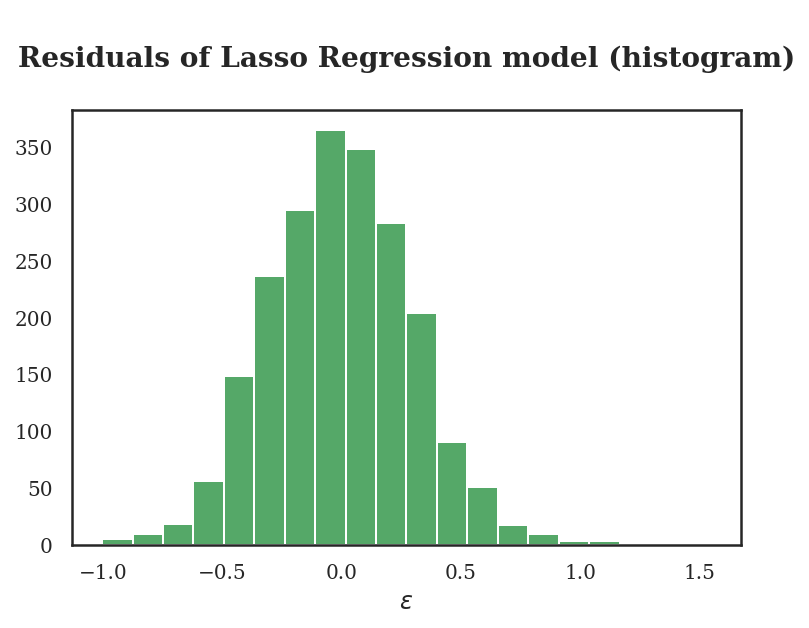

In [13]:
# examine the residuals, to see whether they are normally distributed

y2 = y_train
linear_yhat = model_l.predict(X_train)
yhatdf = pd.DataFrame(dict(y2, yhat = linear_yhat, residuals_l = y2-linear_yhat))

#fig = plt.figure(figsize=(8,6))

sns.set(style="white", font='serif')

plt.title("\nResiduals of Lasso Regression model (histogram)\n", fontsize = 14, fontweight = 'bold')
plt.xlabel(r"$\epsilon$")
plt.tick_params(axis='both', labelsize=10)

plt.hist(yhatdf.residuals_l, bins=20, color='g');

In [14]:
# examine correlation between each predictor and the target y
df_model.corr()['Prog8_overall_measure'].sort_values(ascending=False)

Prog8_overall_measure                 1.000000
Pct_GCSEpup_enter_Ebacc_Lang          0.511808
Num_GCSEpup_all_Ebacc                 0.483262
Avg_num_GCSEs_equiv_pup               0.481308
Pct_GCSEpup_any_qual                  0.409313
Pct_GCSEpup_enter_Ebacc_Maths         0.380818
Pct_GCSEpup_more_onelang              0.368959
Pct_GCSEpup_3_sciences                0.337799
Pct_GCSEpup_enter_Ebacc_Humanities    0.290702
Teachers_FTE                          0.229457
Pct_GCSEpup_enter_Ebacc_Science       0.178632
Num_pupils_GCSEs                      0.170129
School_sixth_form                     0.131887
Pupil_Teacher_ratio                   0.130733
Staff_non_classroom                   0.118632
Mean_Gross_FTE_Sal                    0.117770
Estab_group                           0.087505
School_feeder_sixth_form              0.079350
School_primary                        0.016831
Local_Ed_Auth                        -0.075698
TAs_FTE                              -0.093073
Is_Closed    

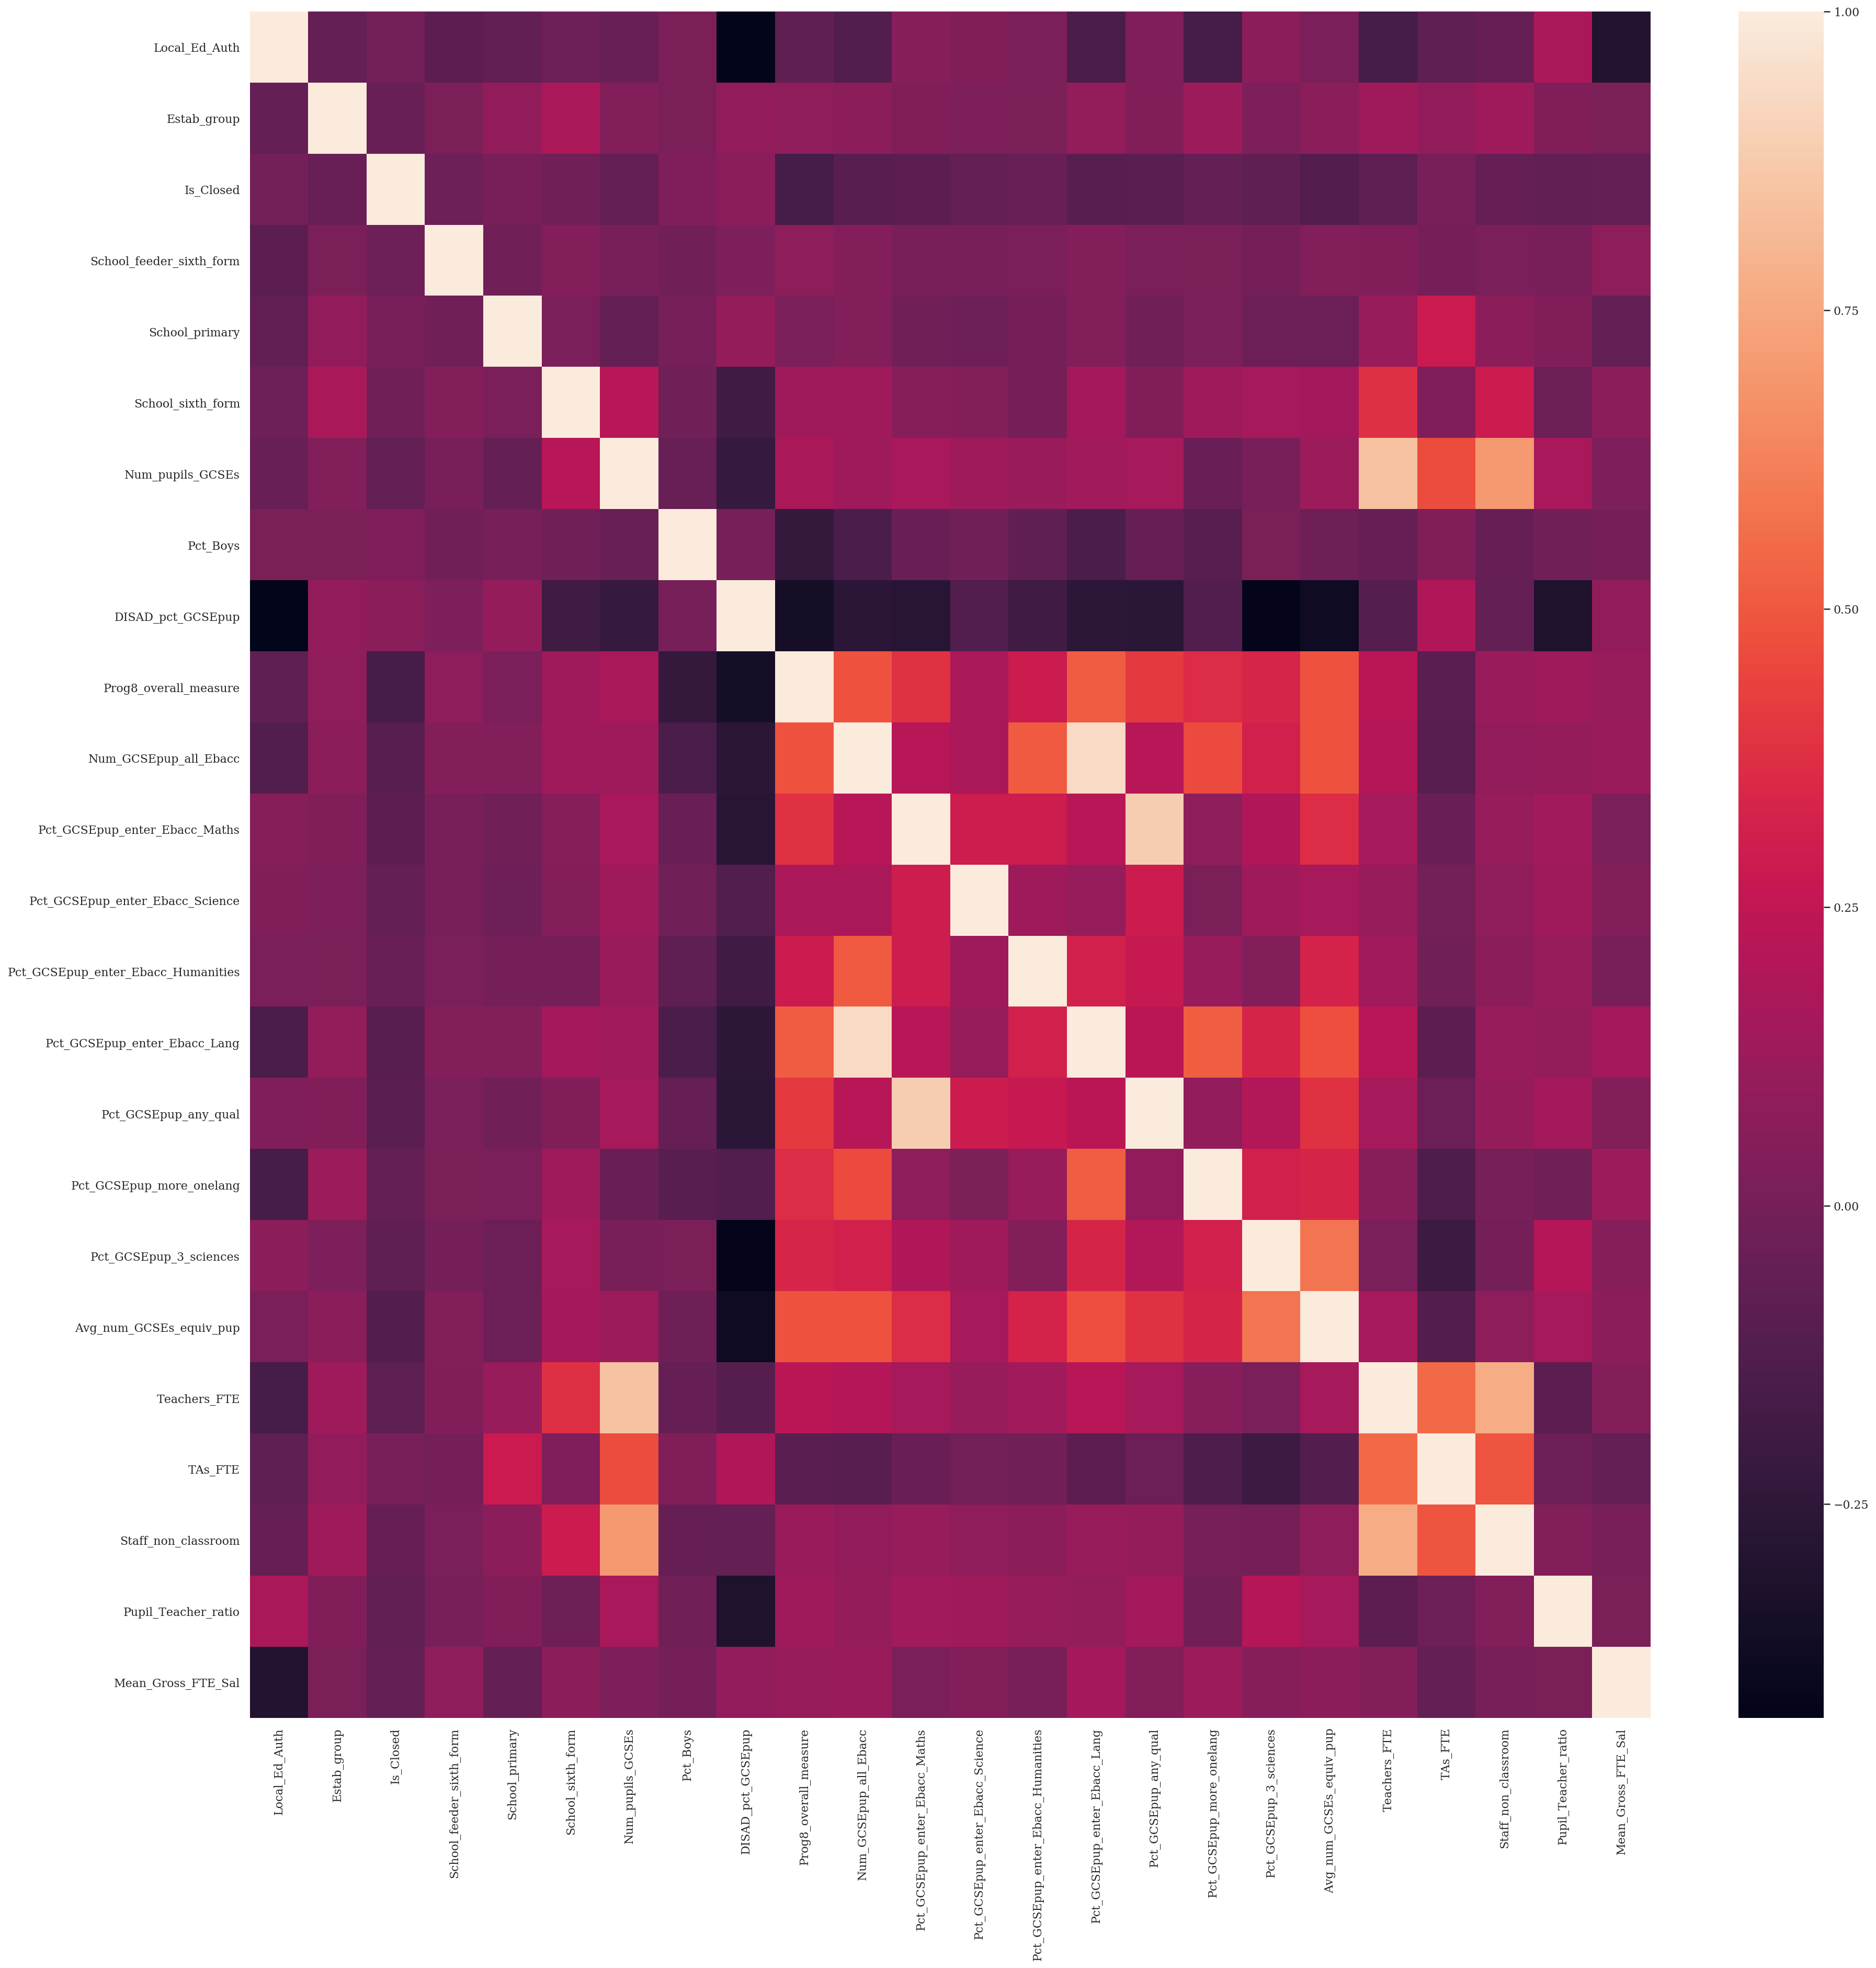

In [15]:
fig = plt.subplots(figsize=(30,30))

sns.heatmap(df_model.corr());

### <font color='green'>a) MinMax scaling</font>

In [16]:
# Re-do train / test split and scaling

X_train_mm, X_test_mm, y_train_mm, y_test_mm = train_test_split(X, y, test_size=0.3, random_state=1, shuffle=True)
scaler = MinMaxScaler()
X_train_mm = pd.DataFrame(scaler.fit_transform(X_train_mm),columns=X_train_mm.columns)
X_test_mm = pd.DataFrame(scaler.transform(X_test_mm),columns=X_test_mm.columns)

In [17]:
linreg_scores(X_train_mm, y_train_mm, X_test_mm, y_test_mm, cv=5)


LINEAR REGRESSION MODEL:      Results
------------------------      -------
Training R2:                  0.7230769200679279
Mean cross-val training R2:   -1.379058796996351e+25
Test R2:                      -3.714786146938333e+24

Intercept:                  -1.985385872869533

LASSO MODEL:                  Results
------------                  -------
Best alpha:                   0.0004297415374992016
Training R2:                  0.6074048836306946
Mean cross-val training R2:   0.5202481830998706
Test R2:                      0.4507413128479951

Intercept:                  -1.920443845901862

RIDGE MODEL:                  Results
------------                  -------
Best alpha:                   2.782559402207126
Training R2:                  0.6690389018241303
Mean cross-val training R2:   0.5123712628480377
Test R2:                      0.42818181454190735

Intercept:                  -1.5982257884569797


In [18]:
# produce and print the Lasso coefficients (the best model)

model_l_mm = LassoCV(n_alphas = 100, max_iter=100000, cv=5)
model_l_mm.fit(X_train_mm, y_train_mm)
score_l_mm_cv = (cross_val_score(model_l_mm, X_train_mm, y_train_mm, cv=5)).mean()
score_l_mm_test = model_l_mm.score(X_test_mm, y_test_mm)

lasso_coefs = pd.DataFrame(list(zip(X_train_mm.columns, model_l_mm.coef_, np.abs(model_l_mm.coef_))), columns = ['variable', 'lasso_coef', 'abs_lasso_coef'])

print(model_l_mm.intercept_)
print(lasso_coefs.shape)
lasso_coefs.sort_values('abs_lasso_coef', ascending=False)[:20]

-1.920443845901862
(815, 3)


,variable,lasso_coef,abs_lasso_coef
8,Pct_GCSEpup_any_qual,1.531313,1.531313
11,Avg_num_GCSEs_equiv_pup,0.611553,0.611553
802,Rel_Denom_Muslim,0.544112,0.544112
2,DISAD_pct_GCSEpup,-0.455727,0.455727
34,Local_Ed_Auth_307.0,0.437156,0.437156
7,Pct_GCSEpup_enter_Ebacc_Lang,0.402158,0.402158
31,Local_Ed_Auth_304.0,0.387403,0.387403
1,Pct_Boys,-0.360953,0.360953
44,Local_Ed_Auth_317.0,0.345585,0.345585
12,Teachers_FTE,0.341227,0.341227


### <font color='green'>b) Save models to disk</font>

In [19]:
# OLS StandardScaler

filename = 'saved_models/GCSE_Final_Model_OLS_regl_30_Sep_19.sav'
pickle.dump(model_l, open(filename, 'wb'))

In [20]:
# OLS MinMax

filename = 'saved_models/GCSE_Final_Model_OLS_regl_mm_30_Sep_19.sav'
pickle.dump(model_l_mm, open(filename, 'wb'))

### <font color='green'>c) Save model results to DataFrame</font>

In [21]:
models_results = pd.DataFrame([[score_l_cv,score_l_test,mean_squared_error(y_test, model_l.predict(X_test))]], columns=['R2_cv_mean', 'R2_test', 'MSE'], index = ['Lasso_OLS_std_scaler'])
models_results.loc['Lasso_OLS_min_max'] = [score_l_mm_cv,score_l_mm_test,mean_squared_error(y_test_mm, model_l_mm.predict(X_test_mm))]
models_results.sort_values(by = 'R2_cv_mean', ascending=False)

,R2_cv_mean,R2_test,MSE
Lasso_OLS_min_max,0.520248,0.450741,0.107638
Lasso_OLS_std_scaler,0.513583,0.443539,0.109049


<a id='dt'></a>

# <font color='blue'>Model 4) Decision Tree</font>

In [22]:
dtrN = DecisionTreeRegressor(max_depth=5)
dtrN.fit(X, y)
dtrN_scores = cross_val_score(dtrN, X, y, cv=5)

In [23]:
print(dtrN_scores, np.mean(dtrN_scores))

[0.15872661 0.25311535 0.21059769 0.34993001 0.49855139] 0.2941842086132295


### <font color='green'>a) Gridsearch the best parameters</font>

In [24]:
# set up Gridsearch params
dtr_params = {
    'max_depth': list(range(1, 20))+[None],
    'max_features': [None, 0.25, 0.5, 0.75, 1],
    'min_samples_split': [5, 10, 20, 50, 80, 100, 200]
}


# set the Gridsearch
model_dt = DecisionTreeRegressor()
dtr_gs = GridSearchCV(model_dt, dtr_params, cv=5, verbose=1, iid=False)

In [25]:
# use the gridsearch model to fit the data
dtr_gs.fit(X, y)
dtr_best = dtr_gs.best_estimator_
print(dtr_gs.best_params_)
print(dtr_gs.best_score_)

Fitting 5 folds for each of 700 candidates, totalling 3500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'max_depth': 14, 'max_features': 0.25, 'min_samples_split': 200}
0.3386326904881264


[Parallel(n_jobs=1)]: Done 3500 out of 3500 | elapsed:  2.1min finished


### <font color='green'>b) Visualise the Decision Tree</font>

In [26]:
# initialize the output file object
dot_data = StringIO()

In [27]:
# use function to plot the Decision Tree

def plot_dt(dt, feature_names=None):
    print('Max depth:', dt.max_depth)
    dot_data = StringIO()
    export_graphviz(dt,
                    out_file=dot_data,
                    filled=True,
                    rounded=True,
                    special_characters=True,
                    feature_names=feature_names
                    )

    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return Image(graph.create_png())

Max depth: 14


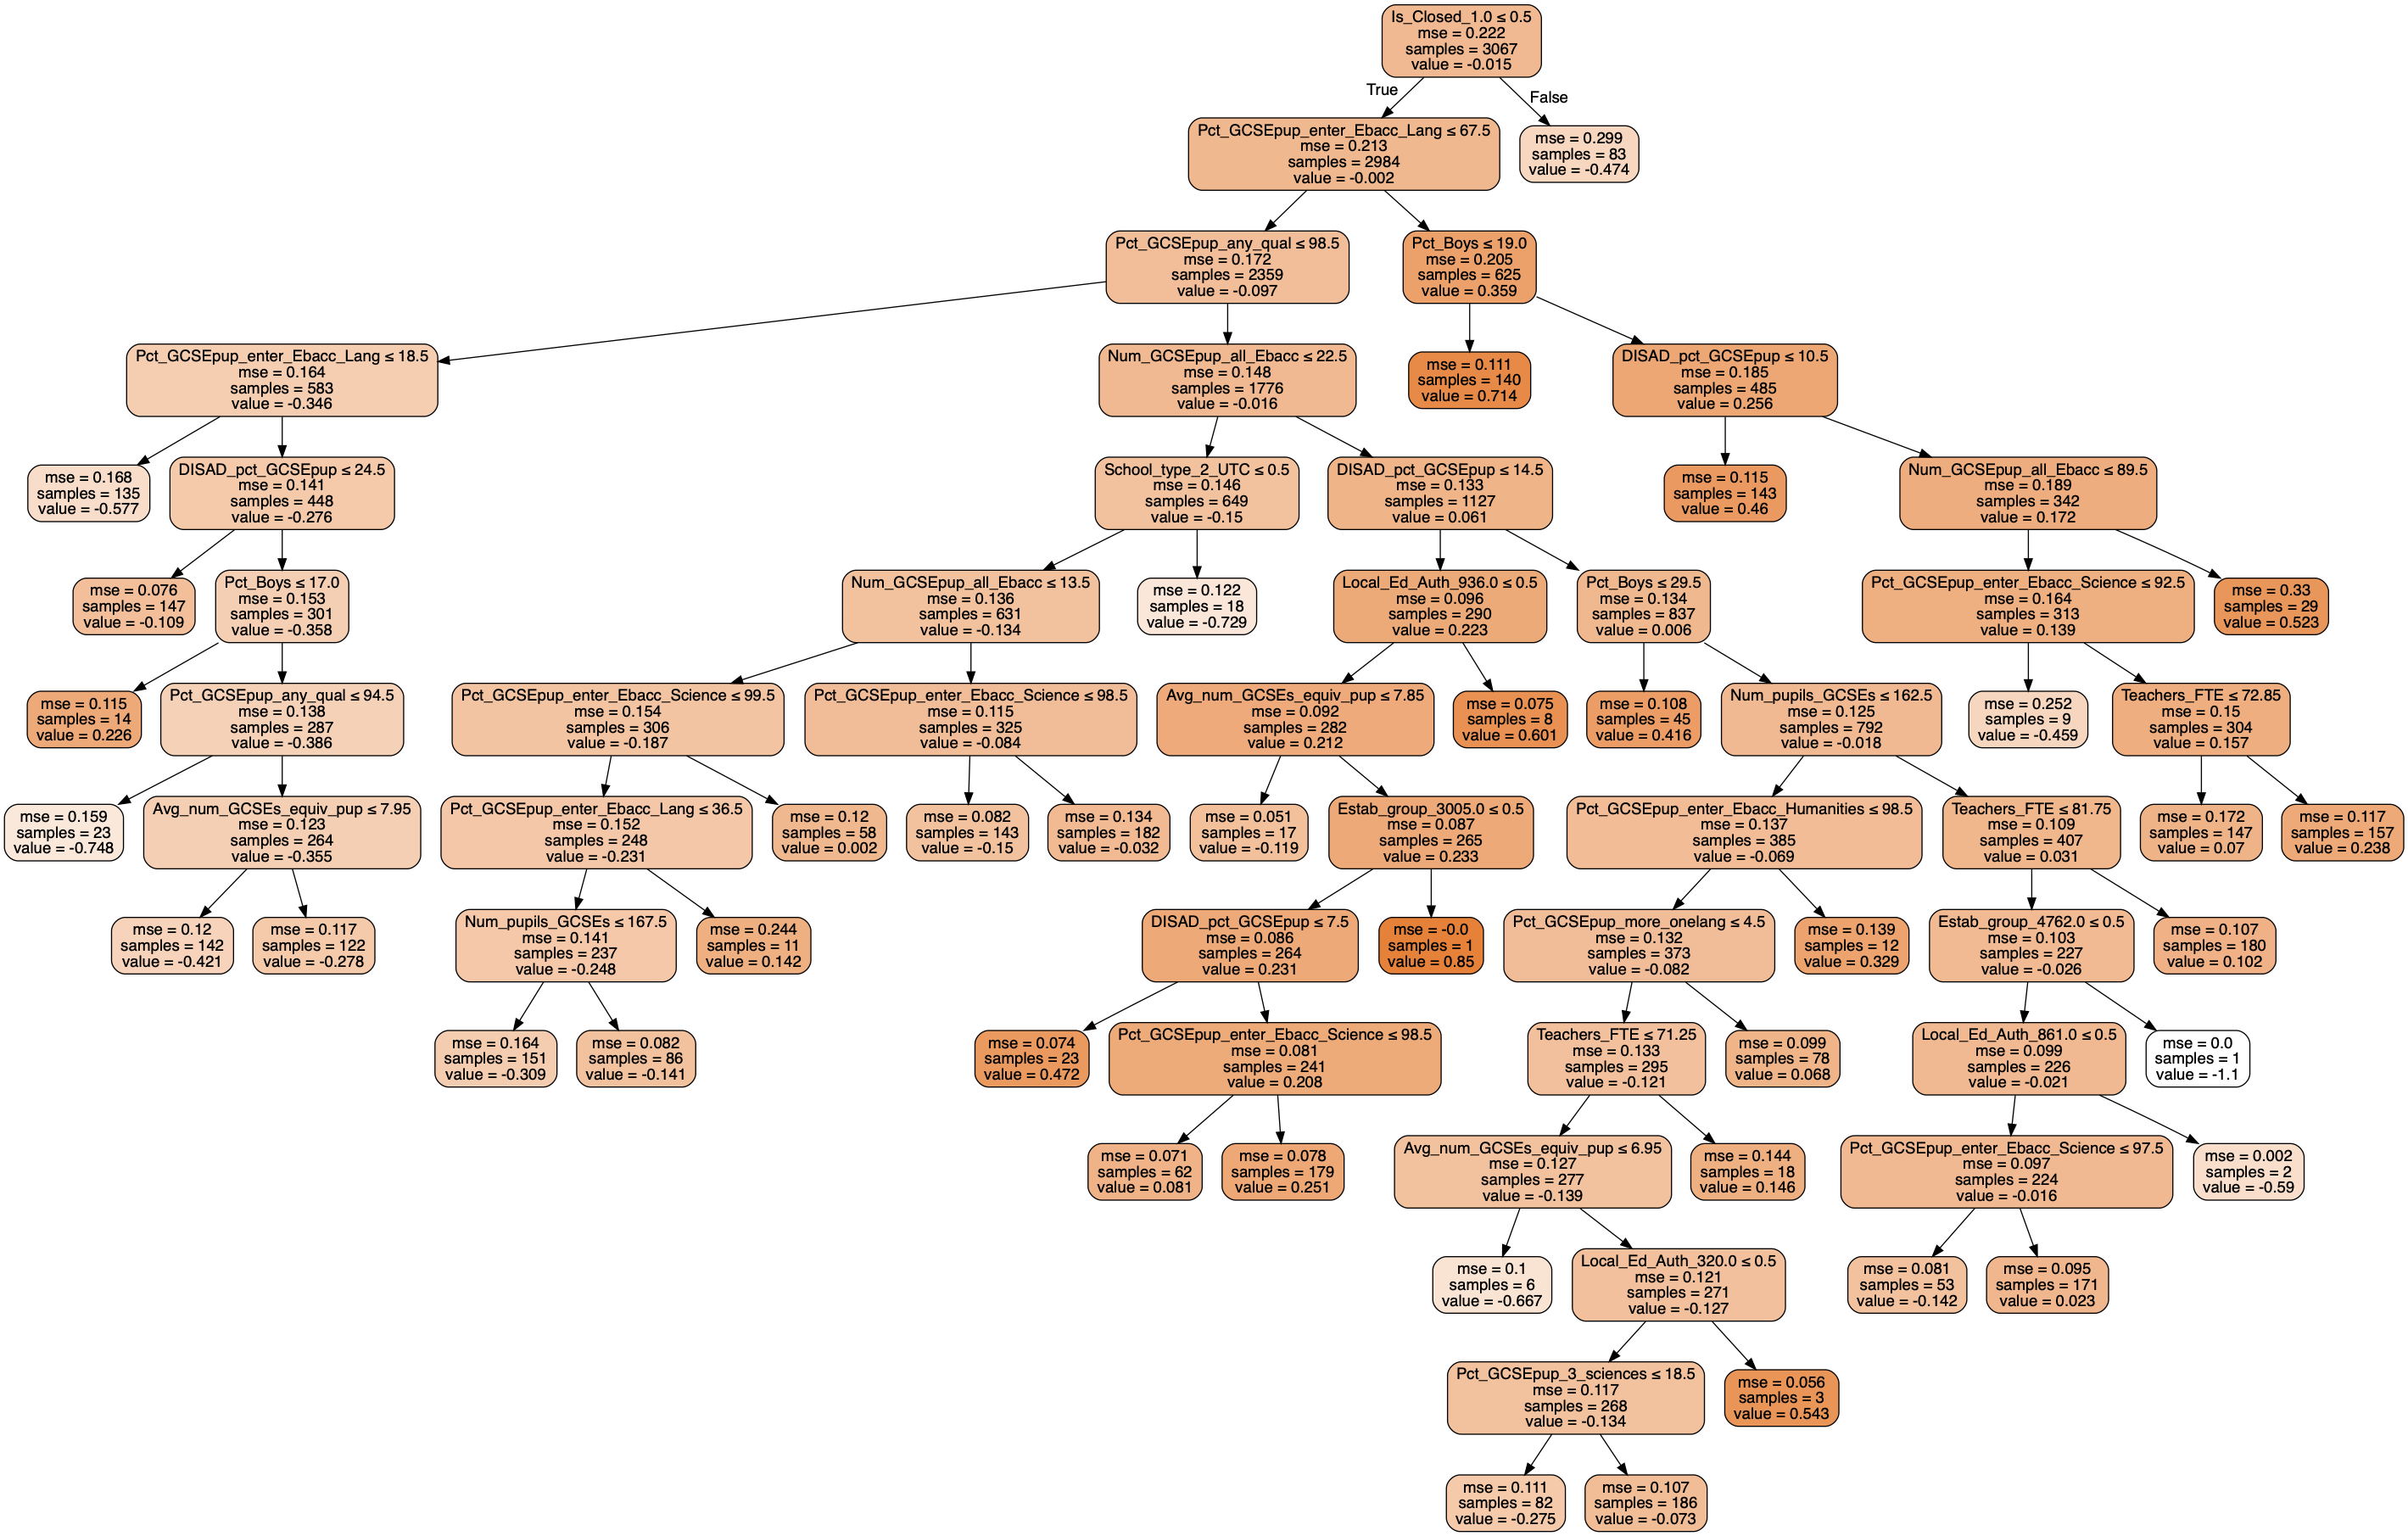

In [28]:
# plot the best model

plot_dt(dtr_best, feature_names=X.columns)

Max depth: 4


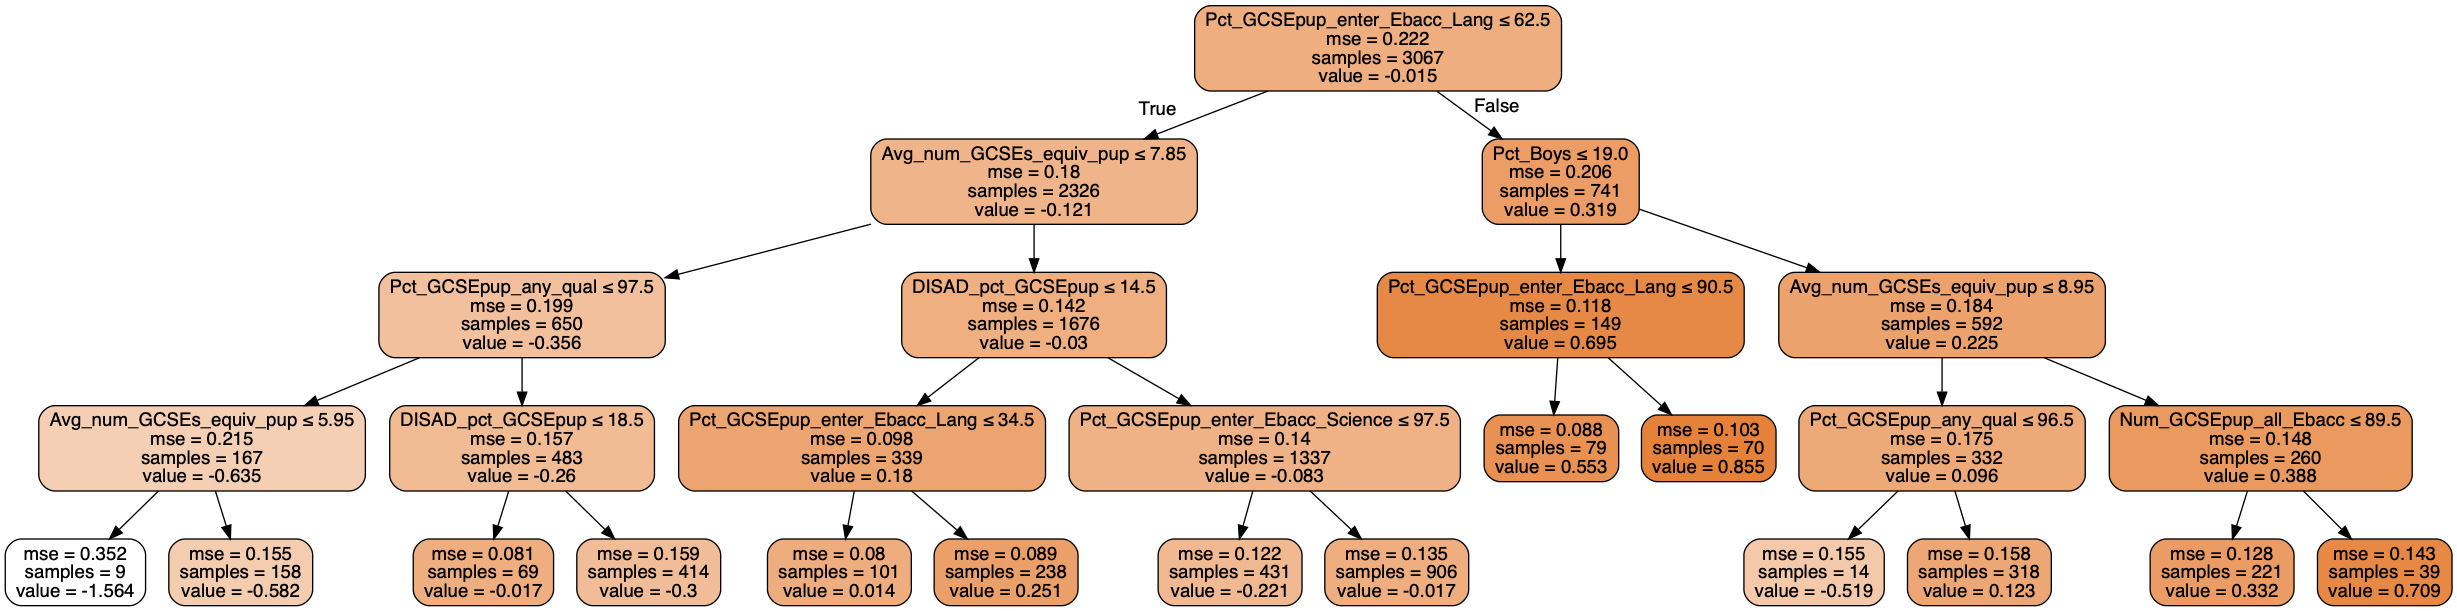

In [29]:
# plot the model with max_depth 4 to see the detail of features at the top of the tree

dtr4 = DecisionTreeRegressor(max_depth=4, max_features = None, min_samples_split=100)
dtr4.fit(X, y)
plot_dt(dtr4, feature_names=X.columns)

### <font color='green'>c) Display Features Importance</font>

In [30]:
# show the features importance

fi = pd.DataFrame({
    'feature': X.columns,
    'importance': dtr_best.feature_importances_
})

fi.sort_values('importance', ascending=False, inplace=True)
fi[:15]

,feature,importance
7,Pct_GCSEpup_enter_Ebacc_Lang,0.368324
8,Pct_GCSEpup_any_qual,0.164744
1,Pct_Boys,0.115616
2,DISAD_pct_GCSEpup,0.084346
3,Num_GCSEpup_all_Ebacc,0.077683
784,Is_Closed_1.0,0.058307
5,Pct_GCSEpup_enter_Ebacc_Science,0.030368
791,School_type_2_UTC,0.020032
12,Teachers_FTE,0.016671
11,Avg_num_GCSEs_equiv_pup,0.016257


### <font color='green'>d) Save models to disk</font>

In [31]:
# Decision Tree

filename = 'saved_models/GCSE_Final_Model_DT_30_Sep_19.sav'
pickle.dump(model_dt, open(filename, 'wb'))

### <font color='green'>e) Save model results to DataFrame</font>

In [32]:
models_results.loc['Decision_Tree'] = [dtr_gs.best_score_,'n/a','n/a']
models_results.sort_values(by = 'R2_cv_mean', ascending=False)

,R2_cv_mean,R2_test,MSE
Lasso_OLS_min_max,0.520248,0.450741,0.107638
Lasso_OLS_std_scaler,0.513583,0.443539,0.109049
Decision_Tree,0.338633,n/a,n/a


<a id='ensemble'></a>

# <font color='blue'>Models 5-8) Ensemble Methods</font>

<a id='bagging'></a>

## <font color='green'>Model 5) Decision Tree Regressor with Bagging</font>

In [33]:
bagging = BaggingRegressor(base_estimator=dtr_best,
                            max_samples=0.8, 
                            max_features=0.4, 
                            n_estimators=10)

bagging.fit(X_train, y_train)
print("Decision Tree Bagging CV training score:   ", 
      cross_val_score(bagging, X_train, y_train,
                    cv=5, n_jobs=1).mean())
print("Decision Tree Bagging test score:\t   ", bagging.score(X_test, y_test))

Decision Tree Bagging CV training score:    0.4037171019153158
Decision Tree Bagging test score:	    0.3601172513093588


### <font color='green'>a) Gridsearch the best parameters</font>

In [34]:
# Gridsearch the Bagging Regressor

model_bag = BaggingRegressor(base_estimator=dtr_best, n_estimators=10)
params = {'max_samples': np.linspace(0.8, 0.4, 3),
          'max_features': range(int(3/4.*X.shape[1]), X.shape[1]+1)}

grid_bag = GridSearchCV(model_bag, param_grid=params, cv=5)
grid_bag.fit(X_train, y_train)
grid_bag.best_estimator_

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                      max_depth=14,
                                                      max_features=0.25,
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=200,
                                                      min_weight_fraction_leaf=0.0,
                                                      presort=False,
                                                      random_state=None,
                                                      splitter='best'),
                 bootstrap=True, bootstrap_features=False, max_features=787,
                 max_sample

In [35]:
print("Cross-val training score for GS Bagging Decision Tree: " + str(grid_bag.best_score_))
print("Test score for GS Bagging Decision Tree: " + str(grid_bag.score(X_test, y_test)))

Cross-val training score for GS Bagging Decision Tree: 0.43625841015095257
Test score for GS Bagging Decision Tree: 0.36961090238488165


In [36]:
model_bag.get_params()

{'base_estimator__criterion': 'mse',
 'base_estimator__max_depth': 14,
 'base_estimator__max_features': 0.25,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 200,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__presort': False,
 'base_estimator__random_state': None,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeRegressor(criterion='mse', max_depth=14, max_features=0.25,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=200, min_weight_fraction_leaf=0.0,
                       presort=False, random_state=None, splitter='best'),
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 

### <font color='green'>b) Save model results to disk</font>

In [37]:
filename = 'saved_models/GCSE_Final_Model_Bagging_30_Sep_19.sav'
pickle.dump(model_bag, open(filename, 'wb'))

### <font color='green'>c) Save model results to DataFrame</font>

In [38]:
models_results.loc['Bagging_DT'] = [grid_bag.best_score_,grid_bag.score(X_test, y_test),mean_squared_error(y_train, grid_bag.predict(X_train))]
models_results.sort_values(by = 'R2_cv_mean', ascending=False)

,R2_cv_mean,R2_test,MSE
Lasso_OLS_min_max,0.520248,0.450741,0.107638
Lasso_OLS_std_scaler,0.513583,0.443539,0.109049
Bagging_DT,0.436258,0.369611,0.122539
Decision_Tree,0.338633,n/a,n/a


<a id='rf'></a>

## <font color='green'>Model 6) Random Forest</font>

In [39]:
model_rf = RandomForestRegressor(n_estimators = 100)
model_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [40]:
print("Cross-val training score for Random Forest: " + str(cross_val_score(model_rf, X_train, y_train, cv=5).mean()))
print("Test score for Random Forest: " + str(model_rf.score(X_test, y_test)))

Cross-val training score for Random Forest: 0.49544737579795967
Test score for Random Forest: 0.41941070427664684


### <font color='green'>a) Gridsearch the best parameters</font>

In [41]:
# gridsearch params
rfr_params = {
    'criterion': ['mse'],
    'n_estimators': [10, 20, 50, 100, 150, 200]
}

# set the gridsearch
model_rf = RandomForestRegressor()
grid_rf = GridSearchCV(model_rf, rfr_params, cv=5, verbose=1, iid=False)
grid_rf.fit(X_train, y_train)
grid_rf.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.6min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [42]:
print("Cross-val training score for GS Random Forest: " + str(cross_val_score(grid_rf.best_estimator_, X_train, y_train, cv=5).mean()))
print("Test score for GS Random Forest: " + str(grid_rf.best_estimator_.score(X_test, y_test)))

Cross-val training score for GS Random Forest: 0.4969821029847745
Test score for GS Random Forest: 0.4194756662504118


In [43]:
model_rf_mm = RandomForestRegressor()
grid_rf_mm = GridSearchCV(model_rf_mm, rfr_params, cv=5, verbose=1, iid=False)
grid_rf_mm.fit(X_train_mm, y_train_mm)
grid_rf_mm.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.6min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [44]:
print("Cross-val training score for GS Random Forest (min_max): " + str(cross_val_score(grid_rf_mm.best_estimator_, X_train_mm, y_train_mm, cv=5).mean()))
print("Test score for GS Random Forest (min_max): " + str(grid_rf_mm.best_estimator_.score(X_test_mm, y_test_mm)))

Cross-val training score for GS Random Forest (min_max): 0.4985685222867466
Test score for GS Random Forest (min_max): 0.420580907774481


### <font color='green'>b) Display Features Importance</font>

In [99]:
features_importance = pd.DataFrame(grid_rf.best_estimator_.feature_importances_,
             columns=['features_importance'],
             index=X.columns
             ).sort_values(by='features_importance', ascending=False)

features_importance[:15]

,features_importance
Pct_GCSEpup_enter_Ebacc_Lang,0.221159
Avg_num_GCSEs_equiv_pup,0.087681
Pct_Boys,0.069912
DISAD_pct_GCSEpup,0.069621
Pct_GCSEpup_any_qual,0.061304
Num_GCSEpup_all_Ebacc,0.044985
Mean_Gross_FTE_Sal,0.033402
Teachers_FTE,0.032253
TAs_FTE,0.031647
Pct_GCSEpup_enter_Ebacc_Science,0.031341


### <font color='green'>c) Save model results to disk</font>

In [46]:
# Random Forest

filename = 'saved_models/GCSE_Final_Model_RF_30_Sep_19.sav'
pickle.dump(model_rf, open(filename, 'wb'))

### <font color='green'>d) Save model results to DataFrame</font>

In [47]:
models_results.loc['Random_Forest'] = [grid_rf.best_score_,grid_rf.score(X_test, y_test),mean_squared_error(y_train, grid_rf.predict(X_train))]
models_results.sort_values(by = 'R2_cv_mean', ascending=False)

,R2_cv_mean,R2_test,MSE
Lasso_OLS_min_max,0.520248,0.450741,0.107638
Lasso_OLS_std_scaler,0.513583,0.443539,0.109049
Random_Forest,0.497801,0.419476,0.0160694
Bagging_DT,0.436258,0.369611,0.122539
Decision_Tree,0.338633,n/a,n/a


<a id='ada'></a>

## <font color='green'>Model 7) Decision Tree Regressor with AdaBoost</font>

In [48]:
base_estimator = DecisionTreeRegressor(max_depth=10)
model_ab = AdaBoostRegressor(base_estimator=base_estimator,
                          n_estimators=300,
                          random_state=1)
model_ab.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=10,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=1.0, loss='linear', n_estimators=300,
                  random

In [49]:
print("Cross-val training score for Ada Boost DT: " + str(cross_val_score(model_ab, X_train, y_train, cv=5).mean()))
print("Test score for Ada Boost DT: " + str(model_ab.score(X_test, y_test)))

Cross-val training score for Ada Boost DT: 0.5020481639356708
Test score for Ada Boost DT: 0.4200594956239491


In [50]:
base_estimator = DecisionTreeRegressor(max_depth=10)
model_ab_mm = AdaBoostRegressor(base_estimator=base_estimator,
                          n_estimators=300,
                          random_state=1)
model_ab_mm.fit(X_train_mm, y_train_mm)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=10,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=1.0, loss='linear', n_estimators=300,
                  random

In [51]:
print("Cross-val training score for Ada Boost DT (min_max): " + str(cross_val_score(model_ab_mm, X_train_mm, y_train_mm, cv=5).mean()))
print("Test score for Ada Boost DT (min_max): " + str(model_ab_mm.score(X_test_mm, y_test_mm)))

Cross-val training score for Ada Boost DT (min_max): 0.5058234245624766
Test score for Ada Boost DT (min_max): 0.4235315269708605


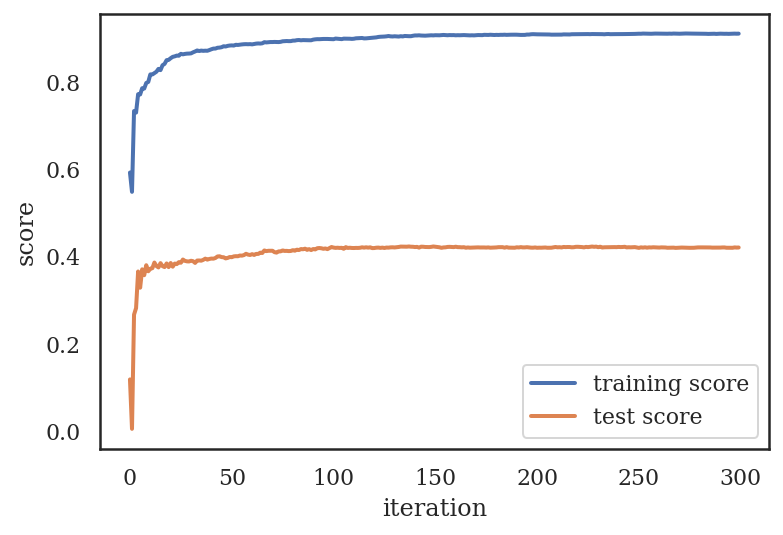

In [52]:
sns.set(style="white", font='serif')

plt.plot(list(model_ab.staged_score(X_train, y_train)),
         label='training score', lw=2)
plt.plot(list(model_ab.staged_score(X_test, y_test)), label='test score', lw=2)
plt.xlabel('iteration')
plt.ylabel('score')
plt.legend()
plt.show()

### <font color='green'>a) Display Features Importance</font>

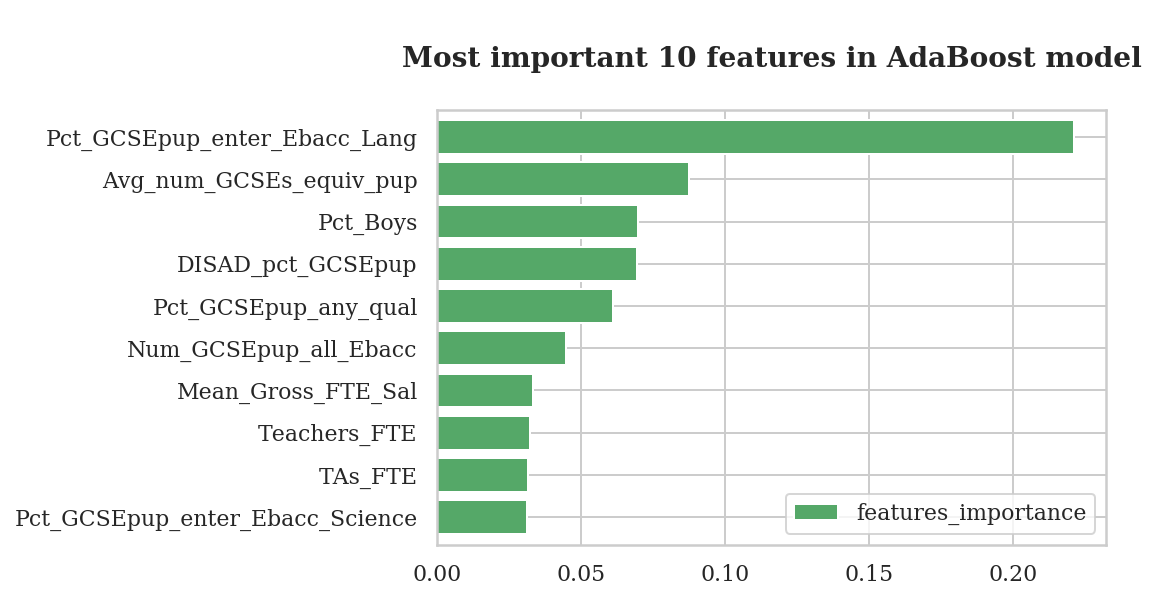

In [100]:
# Graph of Features Importance

graph_data = features_importance[:10]

graph_data.plot(kind='barh', color='g', width=0.8).invert_yaxis()
plt.title("\nMost important 10 features in AdaBoost model\n", fontsize=14, fontweight = 'bold')

plt.show()

In [54]:
# list the features' values in importance

features_importance = pd.DataFrame(model_ab.feature_importances_,
             columns=['importance'],
             index=X.columns
             ).sort_values(by='importance', ascending=False)

features_importance[:15]

,importance
Pct_GCSEpup_enter_Ebacc_Lang,0.125078
Avg_num_GCSEs_equiv_pup,0.091368
DISAD_pct_GCSEpup,0.078049
Num_GCSEpup_all_Ebacc,0.055057
Pct_GCSEpup_any_qual,0.052501
Pct_Boys,0.049286
Teachers_FTE,0.043388
Mean_Gross_FTE_Sal,0.042175
Pct_GCSEpup_enter_Ebacc_Humanities,0.042122
TAs_FTE,0.039351


### <font color='green'>b) Save model results to disk</font>

In [55]:
# AdaBoost (Decision Tree)

filename = 'saved_models/GCSE_Final_Model_AdaB_30_Sep_19.sav'
pickle.dump(model_rf, open(filename, 'wb'))

### <font color='green'>c) Save model results to DataFrame</font>

In [56]:
models_results.loc['AdaBoost_DT'] = [cross_val_score(model_ab, X_train, y_train, cv=5).mean(),model_ab.score(X_test, y_test),mean_squared_error(y_train, model_ab.predict(X_train))]
models_results.sort_values(by = 'R2_cv_mean', ascending=False)

,R2_cv_mean,R2_test,MSE
Lasso_OLS_min_max,0.520248,0.450741,0.107638
Lasso_OLS_std_scaler,0.513583,0.443539,0.109049
AdaBoost_DT,0.502048,0.420059,0.0207064
Random_Forest,0.497801,0.419476,0.0160694
Bagging_DT,0.436258,0.369611,0.122539
Decision_Tree,0.338633,n/a,n/a


### <font color='blue'>Now calculate results for Bagging and Random Forest based on a different number of estimators</font>

In [86]:
def do_cross_val(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv, n_jobs=1,
                             scoring='neg_mean_squared_error')
    return -scores.mean()

In [87]:
def do_cross_val2(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv, n_jobs=1,
                             scoring='r2')
    return scores.mean()

In [88]:
values = sorted(
    list(set(np.logspace(0, 3, num=20, endpoint=True, base=10.0).astype(int))))

In [89]:
len(values)

18

In [90]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
model = DecisionTreeRegressor(max_depth=3, random_state=1)

In [91]:
score_list = []
for n in values:
    models = [('Bagging', BaggingRegressor(random_state=1, n_estimators=n)),
              ('RandomForest', RandomForestRegressor(
                  random_state=1, n_estimators=n))
              ]
    for model in models:
        model[1].fit(X_train, y_train)
        train_r2_cv = do_cross_val2(model[1], X_train, y_train, cv=kf)
        train_score_cv = do_cross_val(model[1], X_train, y_train, cv=kf)
        train_predictions = model[1].predict(X_train)
        test_predictions = model[1].predict(X_test)
        train_score = mean_squared_error(y_train, train_predictions)
        test_score = mean_squared_error(y_test, test_predictions)
        train_score2 = r2_score(y_train, train_predictions)
        test_score2 = r2_score(y_test, test_predictions)
        score_list.append(
            [model[0], n, train_r2_cv, train_score2, test_score2, train_score_cv, train_score, test_score])

In [93]:
mean_squared_error(y_train, model[1].predict(X_train))

0.015481469324324319

In [94]:
df_ensemble_scores = pd.DataFrame(score_list, columns=[
                         'model', 'estimators', 'train_r2_cv','train_r2', 'test_r2','train_mse_cv', 'train_mse', 'test_mse', ])
df_ensemble_scores

,model,estimators,train_r2_cv,train_r2,test_r2,train_mse_cv,train_mse,test_mse
0,Bagging,1,0.050965,0.648540,-0.126084,0.219677,0.081757,0.220678
1,RandomForest,1,0.032366,0.643186,-0.084198,0.223919,0.083002,0.212469
2,Bagging,2,0.274087,0.800447,0.131821,0.167977,0.046420,0.170136
3,RandomForest,2,0.256285,0.795461,0.169653,0.172059,0.047580,0.162722
4,Bagging,4,0.381292,0.863410,0.291748,0.143444,0.031774,0.138795
5,RandomForest,4,0.378594,0.859648,0.310007,0.144009,0.032649,0.135217
6,Bagging,6,0.414753,0.891870,0.320374,0.135454,0.025153,0.133186
7,RandomForest,6,0.413994,0.890987,0.331900,0.135649,0.025359,0.130927
8,Bagging,8,0.436072,0.900422,0.340406,0.130577,0.023164,0.129260
9,RandomForest,8,0.432732,0.900046,0.348176,0.131345,0.023251,0.127737


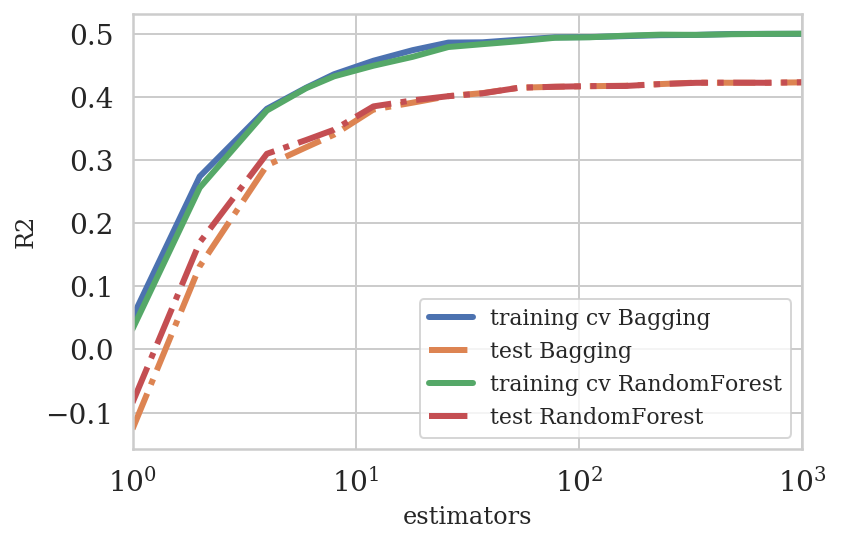

In [95]:
groups = df_ensemble_scores.groupby('model')

fig, ax = plt.subplots()
for group in groups.groups.keys():
    groups.get_group(group).plot(x='estimators', y='train_r2_cv', ax=ax,
                                 label='training cv '+group, lw=3, fontsize=14, logx=True)
    groups.get_group(group).plot(x='estimators', y='test_r2', ax=ax,
                                 label='test ' + group, lw=3, ls='-.', fontsize=14, logx=True)

plt.ylabel('R2')
plt.show()

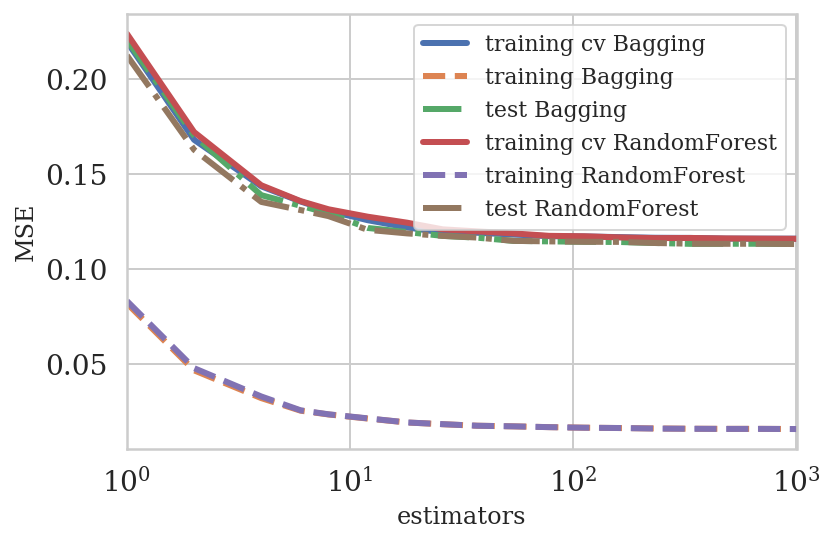

In [96]:
groups = df_ensemble_scores.groupby('model')

fig, ax = plt.subplots()
for group in groups.groups.keys():
    groups.get_group(group).plot(x='estimators', y='train_mse_cv', ax=ax,
                                 label='training cv '+group, lw=3, fontsize=14, logx=True)
    groups.get_group(group).plot(x='estimators', y='train_mse', ax=ax,
                                 label='training '+group, lw=3, ls='--', fontsize=14, logx=True)
    groups.get_group(group).plot(x='estimators', y='test_mse', ax=ax,
                                 label='test ' + group, lw=3, ls='-.', fontsize=14, logx=True)

plt.ylabel('MSE')
plt.show()

In [97]:
# save model outputs to disk

filename = 'saved_models/GCSE_Final_Model_ensemble_RF_Bagging_29_Sep_19.sav'
pickle.dump(model, open(filename, 'wb'))

<a id='pca'></a>

# <font color='blue'>Model 8) Principal Component Analysis (PCA)</font>

In [70]:
# instantiate PCA with n_components
pca = PCA(n_components=800)

In [71]:
# standardize the data
Xpc = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [72]:
# project on the principal components and insert results into a dataframe
cols = ['PC_{}'.format(i) for i in range(1, pca.n_components+1)]
X_pca = pd.DataFrame(pca.fit_transform(Xpc), columns=cols)
X_pca.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_791,PC_792,PC_793,PC_794,PC_795,PC_796,PC_797,PC_798,PC_799,PC_800
0,-0.941996,0.162620,0.251220,-0.574185,0.296325,-0.183959,-0.060814,-0.490143,0.126165,0.026070,...,-0.002369,-0.000969,0.003574,0.000276,0.002496,0.000987,-0.002666,-0.004566,0.002341,0.002307
1,-0.569375,0.723704,0.951051,0.273911,0.743343,-0.688001,0.782607,-0.406312,0.179427,0.024941,...,0.003925,0.000812,0.001415,0.000926,-0.004077,0.000624,-0.001976,-0.007186,-0.001408,-0.000848
2,-0.911164,0.199804,0.295598,-0.488607,0.329840,-0.280714,-0.108681,-0.391312,0.098308,-0.015503,...,-0.014501,0.008772,0.007205,-0.004897,-0.000165,-0.000694,-0.003782,-0.003321,0.001808,0.002197
3,-0.815146,0.311318,0.375580,-0.375288,0.363554,-0.494053,-0.303109,-0.246911,0.027886,0.008358,...,0.007681,-0.014310,-0.003965,0.038044,-0.049514,-0.005148,0.020521,0.029845,0.007253,-0.005809
4,-0.828678,0.312068,0.377752,-0.393083,0.371698,-0.485917,-0.284456,-0.236685,0.028835,-0.052006,...,-0.006199,-0.004419,0.032325,-0.052958,0.068171,-0.093085,0.077640,0.058560,-0.019676,-0.014873


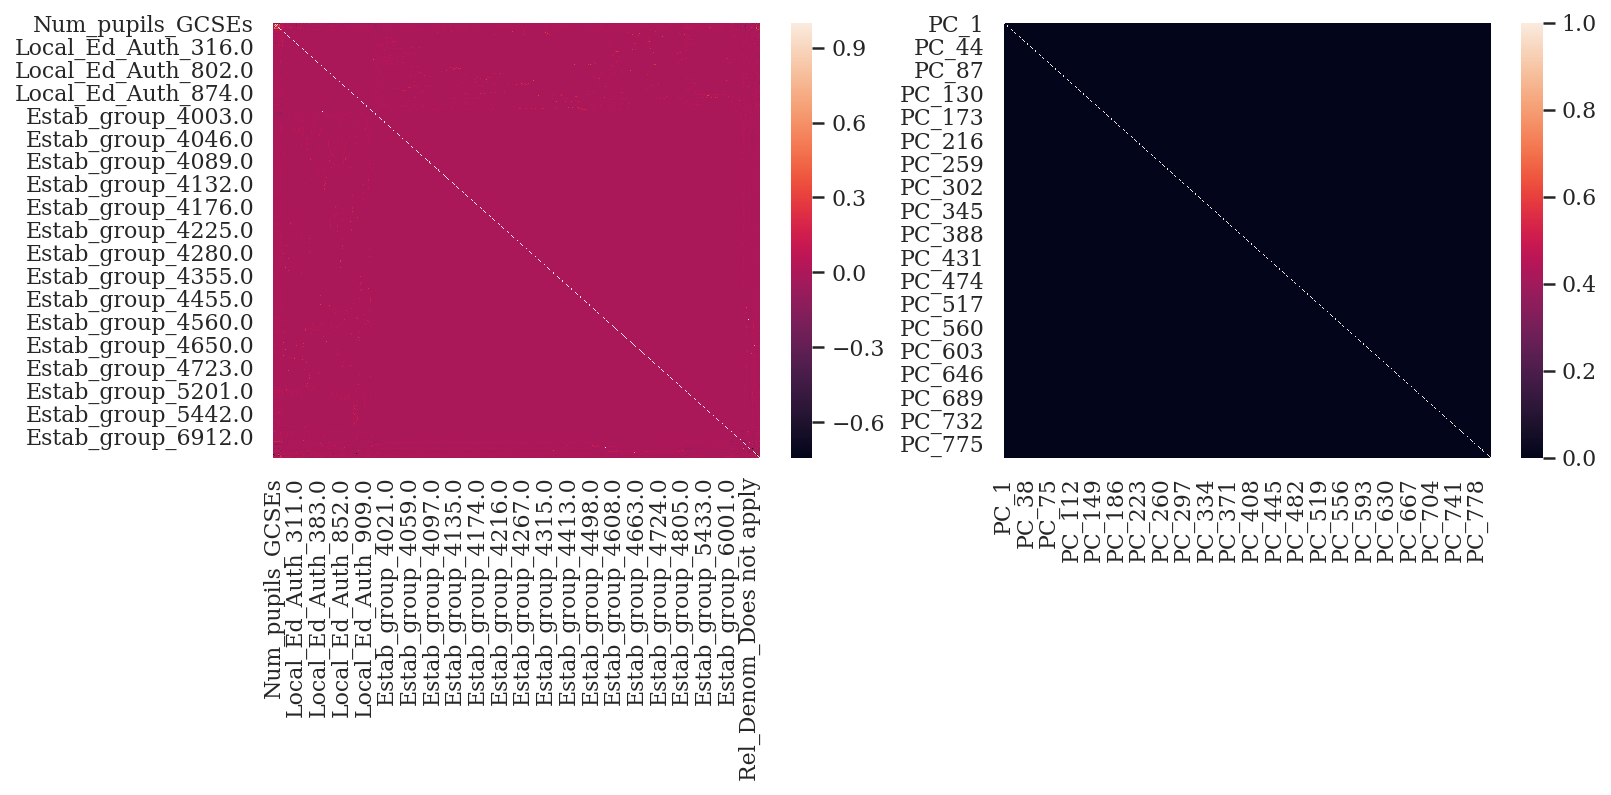

In [73]:
# compare correlations before and after tranformation
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
sns.heatmap(Xpc.corr(), ax=ax[0])
sns.heatmap(X_pca.corr(), ax=ax[1])
plt.show()

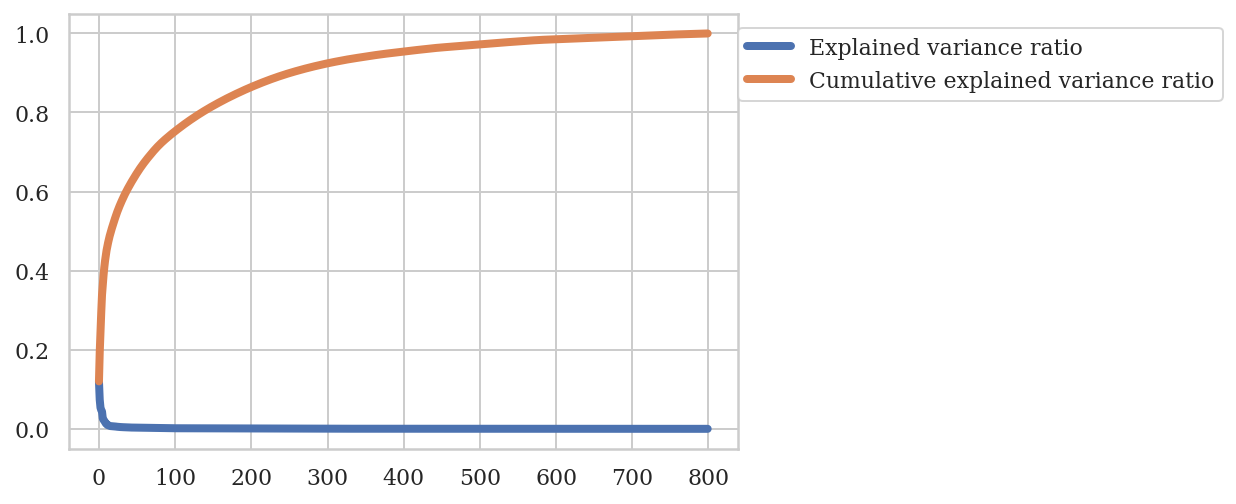

In [74]:
# Produce a scree plot of the explained variance ratio
sns.set(style="whitegrid", font='serif')
plt.plot(pca.explained_variance_ratio_, lw=4, label='Explained variance ratio')
plt.plot(np.cumsum(pca.explained_variance_ratio_), lw=4,
         label='Cumulative explained variance ratio')
plt.legend(loc=(1, 0.8))


plt.show()

<a id='8'></a>

# <font color='blue'>7) Results summary</font>

In [78]:
models_results.sort_values(by = 'R2_cv_mean', ascending=False)

,R2_cv_mean,R2_test,MSE
Lasso_OLS_min_max,0.520248,0.450741,0.107638
Lasso_OLS_std_scaler,0.513583,0.443539,0.109049
AdaBoost_DT,0.502048,0.420059,0.0207064
Random_Forest,0.497801,0.419476,0.0160694
Bagging_DT,0.436258,0.369611,0.122539
Decision_Tree,0.338633,n/a,n/a


END